In [22]:
import pandas as pd
import numpy as np
import time
from nilearn import plotting
from matplotlib import pyplot as plt

In [12]:
base_path = '/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/denoised_data'

In [24]:
# For significant region, plot low and high p-factor average network graphs

# 1. obtain required variables

# network affiliations for 388 regions
attributes = pd.read_csv(f'{base_path}/new_CPM/attributes_NOTro.csv')
networks = attributes['Network']
print(networks.shape)

# p-factor split groups (hi = 1, lo = 0)
cbcl_pca = pd.read_csv(f'{base_path}/bx/cbcl_pca_scores.csv')
p_factor = cbcl_pca.iloc[:,0]
Q1 = np.percentile(p_factor, 25)
Q3 = np.percentile(p_factor, 75)
p_factor_split = np.ones(79)
p_factor_split[p_factor < Q1] = 0
p_factor_split[p_factor > Q3] = 2
print(p_factor_split.shape)

# FC of significant region for each subject
LH_Default_PFC_17_FC = pd.DataFrame(np.zeros((79,388)))
iter = 0
subs = pd.read_csv(f'{base_path}/subj_list_concatenated.csv',header=None)
sub_pc_top_pct = pd.read_csv(f'{base_path}/scripts/unitary-executive-control/sub_pc_selected_regions.csv')
for sub in subs[0]:
    print(f'Working on subject {iter+1}/{sub_pc_top_pct.shape[0]}', end='\r')
    time.sleep(0.00001)
    # Get subject FC matrix
    id = str(sub).zfill(3)
    adj_wei = pd.read_csv(f'{base_path}/Concatenated/no_limbic/z/sub{id}-All_nolimbic_z.csv', dtype={'Subject': str})
    adj_wei = adj_wei.values
    # Get FC of specific region
    adj_wei_df = pd.DataFrame(adj_wei)
    adj_wei_df.columns = attributes['Name']  
    adj_wei_df
    LH_Default_PFC_17_FC.iloc[iter,:] = adj_wei_df['LH_Default_PFC_17']
    iter = iter + 1
print(LH_Default_PFC_17_FC.shape)

# 2. Get average region FC in each p-factor median group

# Split FC df by p-factor median group

LH_Default_PFC_17_FC_lo_p = LH_Default_PFC_17_FC[p_factor_split==0]
print(LH_Default_PFC_17_FC_lo_p.shape)
LH_Default_PFC_17_FC_hi_p = LH_Default_PFC_17_FC[p_factor_split==2]
print(LH_Default_PFC_17_FC_hi_p.shape)

# Average FC of each group and binarize 

# 'percentile' or 'absolute'
method = 'percentile'
percentile = 80
if method == 'absolute':
    cutoff = 0.1

LH_Default_PFC_17_FC_lo_p_avg = np.mean(LH_Default_PFC_17_FC_lo_p)
LH_Default_PFC_17_FC_lo_p_bin = pd.DataFrame(np.zeros(388))
if method == 'percentile':
    cutoff = np.percentile(LH_Default_PFC_17_FC_lo_p_avg,percentile)
LH_Default_PFC_17_FC_lo_p_bin[LH_Default_PFC_17_FC_lo_p_avg>=cutoff] = 1
LH_Default_PFC_17_FC_lo_p_bin.columns = ['Edge']
LH_Default_PFC_17_FC_lo_p_bin.index = networks
print(LH_Default_PFC_17_FC_lo_p_bin.shape)

LH_Default_PFC_17_FC_hi_p_avg = np.mean(LH_Default_PFC_17_FC_hi_p)
LH_Default_PFC_17_FC_hi_p_bin = pd.DataFrame(np.zeros(388))
if method == 'percentile':
    cutoff = np.percentile(LH_Default_PFC_17_FC_hi_p_avg,percentile)
LH_Default_PFC_17_FC_hi_p_bin[LH_Default_PFC_17_FC_hi_p_avg>=cutoff] = 1
LH_Default_PFC_17_FC_hi_p_bin.columns = ['Edge']
LH_Default_PFC_17_FC_hi_p_bin.index = networks
print(LH_Default_PFC_17_FC_hi_p_bin.shape)

(388,)
(79,)
(79, 388)n subject 79/79
(20, 388)
(20, 388)
(388, 1)
(388, 1)


/home/adam/Desktop/apps/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/adam/Desktop/apps/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


#### <b> Function to remove nodes with no edges </b>

In [14]:
def remove_no_edge_nodes(mat,coords,nets):
    # Find nodes with at least one edge
    row_has_ones = np.any(mat, axis=1)
    rows_to_remove = row_has_ones == False
    rows_to_remove = rows_to_remove.astype('int')
    rows_to_remove = rows_to_remove[rows_to_remove==1]
    rows_to_remove = rows_to_remove.index
    rows_to_remove = rows_to_remove.values

    mat = mat.values
    a_del = np.delete(mat, rows_to_remove, 0)

    a_del = pd.DataFrame(a_del)
    col_has_ones = np.any(a_del, axis=0)
    cols_to_remove = col_has_ones == False
    cols_to_remove = cols_to_remove.astype('int')
    cols_to_remove = cols_to_remove[cols_to_remove==1]
    cols_to_remove = cols_to_remove.index
    cols_to_remove = cols_to_remove.values

    a_del = a_del.values
    b_del = np.delete(a_del, cols_to_remove, 1)

    coords = np.delete(coords.values, rows_to_remove, 0)
    nets = np.delete(nets.values, rows_to_remove, 0)

    return b_del, coords, nets

In [25]:
# 3. Reformat data for plotting

roi_coords = pd.read_csv(f'{base_path}/new_CPM/attributes_NOTro.csv')
print(roi_coords.shape)
mni_coords = roi_coords[['x','y','z']]

networks = attributes['Network']

index = mni_coords[attributes['Name']=='LH_Default_PFC_17'].index[0]

lo_matrix = pd.DataFrame(np.zeros((388,388)))
lo_matrix.iloc[index,:] = LH_Default_PFC_17_FC_lo_p_bin['Edge'].values
lo_matrix.iloc[:,index] = LH_Default_PFC_17_FC_lo_p_bin['Edge'].values

lo_matrix, lo_mni_coords, lo_networks = remove_no_edge_nodes(lo_matrix,mni_coords,networks)
print(lo_matrix.shape)
print(lo_mni_coords.shape)
print(lo_networks.shape)

hi_matrix = pd.DataFrame(np.zeros((388,388)))
hi_matrix.iloc[index,:] = LH_Default_PFC_17_FC_hi_p_bin['Edge'].values
hi_matrix.iloc[:,index] = LH_Default_PFC_17_FC_hi_p_bin['Edge'].values

hi_matrix, hi_mni_coords, hi_networks = remove_no_edge_nodes(hi_matrix,mni_coords,networks)
print(hi_matrix.shape)
print(hi_mni_coords.shape)
print(hi_networks.shape)

diff_matrix = pd.DataFrame(np.zeros((388,388)))
diff_matrix.iloc[index,:] = LH_Default_PFC_17_FC_hi_p_bin['Edge'].values - LH_Default_PFC_17_FC_lo_p_bin['Edge'].values
diff_matrix.iloc[:,index] = LH_Default_PFC_17_FC_hi_p_bin['Edge'].values - LH_Default_PFC_17_FC_lo_p_bin['Edge'].values

diff_matrix, diff_mni_coords, diff_networks = remove_no_edge_nodes(diff_matrix,mni_coords,networks)
print(diff_matrix.shape)
print(diff_mni_coords.shape)
print(diff_networks.shape)

(388, 8)
(78, 78)
(78, 3)
(78,)
(78, 78)
(78, 3)
(78,)
(25, 25)
(25, 3)
(25,)


LOW p-factor


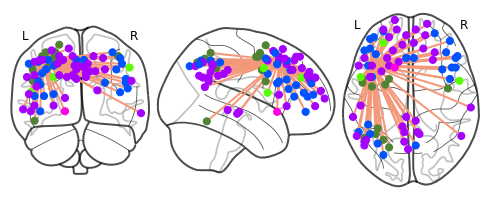

HIGH p-factor


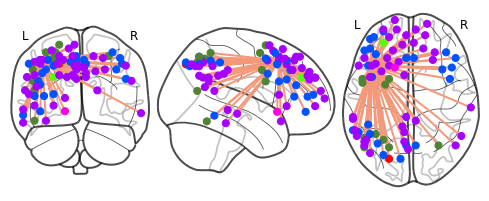

Difference


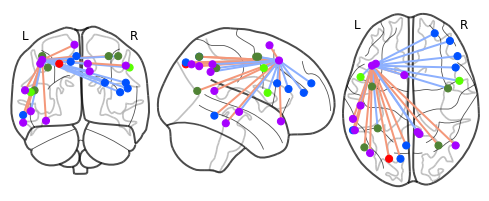

In [26]:
# Low p-factor group
group_colors = {
    1: '#FE0000',
    2: '#FEA500',
    3: '#508334',
    4: '#59FF00',
    5: '#09DDDA',
    6: '#0051FF',
    7: '#A600FF',
    8: '#FF00E4'
    # Add more group-color mappings as needed
}

node_colors = [group_colors[group_number] for group_number in lo_networks]

edge_cmap = 'coolwarm'
print('LOW p-factor')
nilearn.plotting.plot_connectome(lo_matrix, lo_mni_coords, node_color=node_colors, edge_vmax = 2, edge_cmap=edge_cmap,)
plt.show()

# High p-factor group
group_colors = {
    1: '#FE0000',
    2: '#FEA500',
    3: '#508334',
    4: '#59FF00',
    5: '#09DDDA',
    6: '#0051FF',
    7: '#A600FF',
    8: '#FF00E4'
    # Add more group-color mappings as needed
}

node_colors = [group_colors[group_number] for group_number in hi_networks]

edge_cmap = 'coolwarm'
print('HIGH p-factor')
nilearn.plotting.plot_connectome(hi_matrix, hi_mni_coords, node_color=node_colors, edge_vmax = 2, edge_cmap=edge_cmap,)
plt.show()

# Difference
group_colors = {
    1: '#FE0000',
    2: '#FEA500',
    3: '#508334',
    4: '#59FF00',
    5: '#09DDDA',
    6: '#0051FF',
    7: '#A600FF',
    8: '#FF00E4'
    # Add more group-color mappings as needed
}

node_colors = [group_colors[group_number] for group_number in diff_networks]

edge_cmap = 'coolwarm'
print('Difference')
nilearn.plotting.plot_connectome(diff_matrix, diff_mni_coords, node_color=node_colors, edge_vmax = 2, edge_cmap=edge_cmap,)
plt.show()